In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
import math

import torch
import torch_directml
import deepxde as dde

# =====================================================
# 1) YHP SYSTEM: von Karman + roughness (nord, delta_rough)
# =====================================================

def s_function(delta_rough, gamma, r, nord):
    """MATLAB s_function: RAW surface function (unscaled)."""
    r = np.asarray(r, dtype=float)
    s = np.zeros_like(r)
    sp = np.zeros_like(r)
    spp = np.zeros_like(r)

    for k in range(1, nord + 1):
        d = ((-1) ** k) * (1.0 / k)
        arg = 2.0 * np.pi * r * k / gamma
        s += d * np.cos(arg)
        sp += -d * np.sin(arg) * (2.0 * np.pi * k / gamma)
        spp += -d * np.cos(arg) * ((2.0 * np.pi * k / gamma) ** 2)

    return s, sp, spp


def amplitude(gamma, delta_rough, nord):
    x = np.linspace(0.0, gamma, 500)
    s, _, _ = s_function(delta_rough, gamma, x, nord)
    return np.max(s)


def s_scaled(delta_rough, gamma, r, nord, max_s):
    s, sp, spp = s_function(delta_rough, gamma, r, nord)
    if max_s != 0.0:
        factor = delta_rough / max_s
    else:
        factor = 0.0
    s *= factor
    sp *= factor
    spp *= factor
    return s, sp, spp


def karmanode(x, y):
    """
    VK ODE system.
    y[0]=f, y[1]=g, y[2]=h, y[3]=f', y[4]=g'
    """
    f = y[0, :]
    g = y[1, :]
    h = y[2, :]
    df = y[3, :]
    dg = y[4, :]

    uprime = f * f - (g + 1.0) * (g + 1.0) + h * df
    vprime = 2.0 * f * (g + 1.0) + h * dg

    dy_dx = np.vstack((
        df,          # f'
        dg,          # g'
        -2.0 * f,    # h'
        uprime,      # f''
        vprime       # g''
    ))
    return dy_dx


def karmanbc(ya, yb):
    """
    BC: f(0)=0, g(0)=0, h(0)=0, f(∞)=0, g(∞)=-1
    """
    return np.array([
        ya[0],
        ya[1],
        ya[2],
        yb[0],
        yb[1] + 1.0,
    ])


def karmanpde2(x, y, fr, gr, hr, dfr, dgr, xr,
               delta_rough, gamma, r, dr, nord, max_s):
    """
    YHP marching ODE system.
    """
    # Interpolation from previous-step solution
    f1 = np.interp(x, xr, fr)
    g1 = np.interp(x, xr, gr)
    h1 = np.interp(x, xr, hr)
    # dfr, dgr are also interpolated but not used explicitly in equations:
    df1 = np.interp(x, xr, dfr)
    dg1 = np.interp(x, xr, dgr)

    # Roughness surface (fixed r)
    s, sp, spp = s_scaled(delta_rough, gamma, r, nord, max_s)

    f = y[0, :]
    g = y[1, :]
    h = y[2, :]
    df = y[3, :]
    dg = y[4, :]

    # Equations
    eq1 = -2.0 * f1 - r * (f - f1) / dr

    term1_2 = r * f1 * (f - f1) / dr
    term2_2 = h1 * df
    term3_2 = (1.0 + (r - dr) * sp * spp / (1.0 + sp**2)) * (f1**2)
    term4_2 = (1.0 + g1)**2 / (1.0 + sp**2)
    term5 = 1.0 + sp**2
    eq2 = (term1_2 + term2_2 + term3_2 - term4_2) / term5

    term1_3 = r * f1 * (g - g1) / dr
    term2_3 = h1 * dg
    term3_3 = 2.0 * f1 * (1.0 + g1)
    eq3 = (term1_3 + term2_3 + term3_3) / term5

    dy_dx = np.vstack((
        df,   # y1' = y4
        dg,   # y2' = y5
        eq1,  # y3'
        eq2,  # y4'
        eq3   # y5'
    ))
    return dy_dx


def solve_yhp_mean_profiles(delta_rough, nord,
                            upper_z=10.0, gamma=1.0, nmax=100):
    """
    Solve YHP mean-flow profiles (fbar,gbar,hbar) for a single delta_rough and nord.
    Returns: eta_grid, fbar, gbar, hbar
    """
    max_s = amplitude(gamma, delta_rough, nord)
    dr = gamma / nmax

    # Seed with base VK (smooth)
    z_mesh = np.linspace(0.0, upper_z, 100)
    y_init = np.zeros((5, z_mesh.size))
    y_init[0, :] = 0.1   # f
    y_init[1, :] = -1.0  # g
    y_init[2, :] = -1.0  # h
    y_init[3, :] = 0.0   # f'
    y_init[4, :] = 0.0   # g'

    sol = solve_bvp(karmanode, karmanbc, z_mesh, y_init,
                    tol=1e-8, max_nodes=10000)
    if sol.status != 0:
        print("WARNING: base-flow BVP did not converge, status =", sol.status)

    xvK = np.linspace(0.0, upper_z, 2000)
    yvK = sol.sol(xvK)
    fr = yvK[0, :]
    gr = yvK[1, :]
    hr = yvK[2, :]
    dfr = yvK[3, :]
    dgr = yvK[4, :]
    xr = xvK

    fall = []
    gall = []
    hall = []
    dfall = []
    dgall = []

    for n in range(1, nmax + 1):
        r = n * dr
        y_init_n = np.vstack((fr, gr, hr, dfr, dgr))
        sol_n = solve_bvp(
            lambda x, y: karmanpde2(
                x, y, fr, gr, hr, dfr, dgr, xr,
                delta_rough, gamma, r, dr, nord, max_s
            ),
            karmanbc,
            xr,
            y_init_n,
            tol=1e-8,
            max_nodes=10000
        )
        if sol_n.status != 0:
            print(f"  WARNING: BVP did not converge at n={n}, status={sol_n.status}")

        y_n = sol_n.sol(xr)
        fr = y_n[0, :]
        gr = y_n[1, :]
        hr = y_n[2, :]
        dfr = y_n[3, :]
        dgr = y_n[4, :]

        fall.append(fr)
        gall.append(gr)
        hall.append(hr)
        dfall.append(dfr)
        dgall.append(dgr)

    fall = np.array(fall)
    gall = np.array(gall)
    hall = np.array(hall)

    fbar = fall.mean(axis=0)
    gbar = gall.mean(axis=0)
    hbar = hall.mean(axis=0)

    return xr, fbar, gbar, hbar  # xr is eta-grid here (0..upper_z)


def generate_obs_profiles_from_yhp(Re, delta_rough, nord,
                                   r_obs, L, n_z_obs,
                                   upper_z=10.0, gamma=1.0, nmax=100):
    """
    Generate U,V,W profiles at r=r_obs from YHP mean flow.
    Observation data for PINN:
      X_obs: (N,2) [r,z]
      U_obs, V_obs, W_obs: (N,1)
      z_obs: (N,1)
    """
    eta_grid, fbar, gbar, hbar = solve_yhp_mean_profiles(
        delta_rough, nord, upper_z=upper_z, gamma=gamma, nmax=nmax
    )

    delta_Re = Re ** (-0.5)

    z_obs = np.linspace(0.0, L, n_z_obs)
    eta_obs = z_obs 

    # Solution in η is defined on 0..upper_z, clip outside range
    eta_obs_clipped = np.clip(eta_obs, eta_grid[0], eta_grid[-1])

    f_obs = np.interp(eta_obs_clipped, eta_grid, fbar)
    g_obs = np.interp(eta_obs_clipped, eta_grid, gbar)
    h_obs = np.interp(eta_obs_clipped, eta_grid, hbar)

    U_obs = (r_obs * f_obs).reshape(-1, 1)
    V_obs = (r_obs * g_obs).reshape(-1, 1)
    W_obs = (h_obs).reshape(-1, 1)

    X_obs = np.column_stack(
        [r_obs * np.ones_like(z_obs), z_obs]
    ).astype(np.float32)

    z_obs = z_obs.reshape(-1, 1).astype(np.float32)

    return X_obs, U_obs.astype(np.float32), V_obs.astype(np.float32), \
        W_obs.astype(np.float32), z_obs


# =====================================================
# 2) PINN PART (imposed with YHP)
# =====================================================

device = torch_directml.device()
torch.set_default_device(device)
torch.set_default_dtype(torch.float32)

L = 10.0
r_min = 0.1
r_max = 1.0
geom = dde.geometry.Rectangle([r_min, 0.0], [r_max, L])


def wall_height(r, delta_rough):
    # r: torch tensor (N,1)
    return delta_rough * torch.cos(2.0 * math.pi * r)


Re_list = [196]
delta_rough_list = [0.0, 0.08, 0.12, 0.16, 0.2]  # YHP roughness heights
nord = 1  # YHP geometry order

layer_sizes = [4]
neuron_sizes = [64]

# ---------------------------
# Clenshaw–Curtis
# ---------------------------
def clenshaw_curtis_nodes_weights(N, a=-1.0, b=1.0):
    if N < 1:
        raise ValueError("N must be >= 1.")
    k = np.arange(0, N + 1)
    x = np.cos(np.pi * k / N)
    w = np.zeros(N + 1, dtype=float)
    if N % 2 == 0:
        m = np.arange(1, N // 2)
        v = np.zeros_like(k, dtype=float)
        for j in m:
            v += (np.cos(2 * j * np.pi * k / N) / (4 * j * j - 1.0))
        w = (2.0 / N) * (1.0 - v - (np.cos(np.pi * k) / (N * N - 1.0)))
    else:
        m = np.arange(1, (N + 1) // 2)
        v = np.zeros_like(k, dtype=float)
        for j in m:
            v += (np.cos(2 * j * np.pi * k / N) / (4 * j * j - 1.0))
        w = (2.0 / N) * (1.0 - v)
    xm = 0.5 * (a + b) + 0.5 * (b - a) * x
    wm = 0.5 * (b - a) * w
    return xm, wm


N_r, N_z = 32, 128
R_nodes, W_r = clenshaw_curtis_nodes_weights(N_r, a=r_min, b=r_max)
Z_nodes, W_z = clenshaw_curtis_nodes_weights(N_z, a=0.0,   b=L)

RR, ZZ = np.meshgrid(R_nodes, Z_nodes, indexing="xy")
Wr, Wz = np.meshgrid(W_r,     W_z,     indexing="xy")
W2D = (Wr * Wz).reshape(-1, 1)

domain_cc = np.column_stack([RR.reshape(-1), ZZ.reshape(-1)]).astype(np.float32)

R_nodes_t = torch.tensor(R_nodes, dtype=torch.float32, device=device).view(1, -1)
Z_nodes_t = torch.tensor(Z_nodes, dtype=torch.float32, device=device).view(1, -1)
W_r_t     = torch.tensor(W_r,     dtype=torch.float32, device=device).view(1, -1)
W_z_t     = torch.tensor(W_z,     dtype=torch.float32, device=device).view(1, -1)


def cc_weight_rz(r, z):
    dist_r = torch.abs(r - R_nodes_t)
    idx_r  = torch.argmin(dist_r, dim=1, keepdim=True)
    dist_z = torch.abs(z - Z_nodes_t)
    idx_z  = torch.argmin(dist_z, dim=1, keepdim=True)
    w_r = torch.gather(W_r_t.repeat(r.shape[0], 1), 1, idx_r)
    w_z = torch.gather(W_z_t.repeat(z.shape[0], 1), 1, idx_z)
    return w_r * w_z


# ---------------------------
# PDE + BCs (with YHP BCs)
# ---------------------------
def make_pde(Re, delta_rough):
    def pde(x, y):
        r = x[:, 0:1]
        z = x[:, 1:2]

        U = y[:, 0:1]
        V = y[:, 1:2]
        W = y[:, 2:3]
        P = y[:, 3:4]

        U_r = dde.grad.jacobian(y, x, i=0, j=0)
        U_z = dde.grad.jacobian(y, x, i=0, j=1)
        V_r = dde.grad.jacobian(y, x, i=1, j=0)
        V_z = dde.grad.jacobian(y, x, i=1, j=1)
        W_r = dde.grad.jacobian(y, x, i=2, j=0)
        W_z = dde.grad.jacobian(y, x, i=2, j=1)
        P_r = dde.grad.jacobian(y, x, i=3, j=0)
        P_z = dde.grad.jacobian(y, x, i=3, j=1)

        U_rr = dde.grad.jacobian(U_r, x, j=0)
        U_zz = dde.grad.jacobian(U_z, x, j=1)
        V_rr = dde.grad.jacobian(V_r, x, j=0)
        V_zz = dde.grad.jacobian(V_z, x, j=1)
        W_rr = dde.grad.jacobian(W_r, x, j=0)
        W_zz = dde.grad.jacobian(W_z, x, j=1)

        # Rotating-disk PDE (unchanged)
        eq1 = (1.0 / r) * (U + r * U_r) + W_z
        eq2 = U * U_r + W * U_z - (V + r) ** 2 / r - (1.0 / Re) * (U_zz + (1.0 / r) * U_r + U_rr - U / (r ** 2)) + P_r
        #eq2 = U * U_r + W * U_z - V**2 / r - (1.0 / Re) * (U_zz + (1.0 / r) * U_r + U_rr - U / (r ** 2)) + P_r
        eq3 = U * V_r + W * V_z + (U * V) / r + 2.0 * U - (1.0 / Re) * (V_zz + (1.0 / r) * V_r + V_rr - V / (r ** 2))
        #eq3 = U * V_r + W * V_z + (U * V) / r  - (1.0 / Re) * (V_zz + (1.0 / r) * V_r + V_rr - V / (r ** 2))
        eq4 = U * W_r + W * W_z + P_z - (1.0 / Re) * ((1.0 / r) * W_r + W_rr + W_zz)

        # Clenshaw–Curtis weight for PDE
        w_cc = cc_weight_rz(r, z)
        s = torch.sqrt(torch.clamp(w_cc, min=1e-30))

        # ---- WAVY BOTTOM WALL: z = s(r) ----
        z_wall = wall_height(r, delta_rough)
        tol = 5e-10  # tolerance for proximity to the wall
        mask_bottom = (torch.abs(z - z_wall) < tol).float()
        # --- YHP bottom boundary (disk): U=0, V=0, W=0 ---
        eq5 = mask_bottom * U
        eq6 = mask_bottom * V
        eq7 = mask_bottom * W

        # --- Far field (z=L): U=0, V=-r, W unchanged here ---
        mask_top = (torch.abs(z - L) < 1e-20).float()
        eq8  = mask_top * U
        eq9  = mask_top * (V + r)

        return [s * eq1, s * eq2, s * eq3, s * eq4,
                s * eq5, s * eq6, s * eq7, s * eq8, s * eq9]
    return pde


# =========================================
# 3) Training loop (with YHP obs_BC)
# =========================================

base_dir = "Outputs_PINN_YHP_delta_sweep_196"
os.makedirs(base_dir, exist_ok=True)

for Re in Re_list:
    for delta_rough in delta_rough_list:
        print(f"\n=== YHP PINN: Re={Re}, delta_rough={delta_rough} ===")

        pde = make_pde(Re, delta_rough=delta_rough)

        # ---- Obs profiles at r=1 from YHP ----
        X_obs, U_obs, V_obs, W_obs, z_obs = generate_obs_profiles_from_yhp(
            Re=Re,
            delta_rough=delta_rough,
            nord=nord,
            r_obs=1.0,
            L=L,
            n_z_obs=200,
            upper_z=10.0,
            gamma=1.0,
            nmax=100,
        )

        print("  X_obs shape:", X_obs.shape)
        print("  z range     :", float(z_obs.min()), "→", float(z_obs.max()))
        print("  U min/max   :", float(U_obs.min()), "→", float(U_obs.max()))
        print("  V min/max   :", float(V_obs.min()), "→", float(V_obs.max()))
        print("  W min/max   :", float(W_obs.min()), "→", float(W_obs.max()))

        # Plot obs profiles for inspection
        fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
        axes[0].plot(z_obs, U_obs[:, 0])
        axes[0].set_xlabel("z"); axes[0].set_ylabel("U(r=1,z)")
        axes[0].set_title("YHP U profile (obs)")

        axes[1].plot(z_obs, V_obs[:, 0])
        axes[1].set_xlabel("z"); axes[1].set_ylabel("V(r=1,z)")
        axes[1].set_title("YHP V profile (obs)")

        axes[2].plot(z_obs, W_obs[:, 0])
        axes[2].set_xlabel("z"); axes[2].set_ylabel("W(r=1,z)")
        axes[2].set_title("YHP W profile (obs)")

        plt.tight_layout()
        fig_dir = os.path.join(base_dir, "figs_obs")
        os.makedirs(fig_dir, exist_ok=True)
        fig.savefig(os.path.join(
            fig_dir,
            f"yhp_obs_profiles_z_Re{int(Re)}_delta{delta_rough:.3f}.png"
        ), dpi=200)
        plt.close(fig)

        # PointSetBC: U,V,W obs coming from YHP
        bc_U = dde.icbc.PointSetBC(X_obs, U_obs, component=0)
        bc_V = dde.icbc.PointSetBC(X_obs, V_obs, component=1)
        bc_W = dde.icbc.PointSetBC(X_obs, W_obs, component=2)
        bcs = [bc_U, bc_V, bc_W]

        # Global CC grid (RR, ZZ) already defined
        RR_flat = RR.reshape(-1)
        ZZ_flat = ZZ.reshape(-1)

        # NumPy version of the same wall-height form
        s_wall_np = delta_rough * np.cos(2.0 * np.pi * RR_flat)
        mask_fluid = ZZ_flat >= s_wall_np

        domain_cc_local = np.column_stack([
            RR_flat[mask_fluid],
            ZZ_flat[mask_fluid],
        ]).astype(np.float32)

        data = dde.data.PDE(
            geom, pde, bcs,
            num_domain=0,
            num_boundary=0,
            num_test=2000,
            anchors=domain_cc_local,
        )

        delta_Re = Re ** (-0.5)

        def feature_transform(x):
            r = x[:, 0:1]
            z = x[:, 1:2]
            eta = z / delta_Re
            return torch.cat([r, eta], dim=1)

        for l in layer_sizes:
            for neu in neuron_sizes:
                layers = [2] + [neu] * l + [4]
                net = dde.nn.FNN(layers, "tanh", "Glorot uniform")
                net.apply_feature_transform(feature_transform)

                def output_transform(x, y):
                    r = x[:, 0:1]
                    U = r * y[:, 0:1]
                    V = r * y[:, 1:2]
                    W = delta_Re * y[:, 2:3]
                    P = (delta_Re ** 2) * y[:, 3:4]
                    return torch.cat([U, V, W, P], dim=1)

                net.apply_output_transform(output_transform)
                net.to(device)

                output_dir = os.path.join(
                    base_dir,
                    f"YHP_Re{int(Re)}_delta{delta_rough:.3f}_{neu}x{l}"
                )
                os.makedirs(output_dir, exist_ok=True)

                model = dde.Model(data, net)
                model.compile("adam", lr=5e-4)

                losshistory_adam, train_state_adam = model.train(
                    iterations=2000,
                    model_save_path=os.path.join(output_dir, "model_adam"),
                    verbose=1,
                    display_every=500,
                )
                dde.saveplot(
                    losshistory_adam, train_state_adam,
                    issave=True, isplot=False, output_dir=output_dir
                )



=== YHP PINN: Re=196, delta_rough=0.12 ===
  X_obs shape: (200, 2)
  z range     : 0.0 → 10.0
  U min/max   : -2.202285582081824e-22 → 0.16002529859542847
  V min/max   : -1.0 → -9.10560244117885e-23
  W min/max   : -0.930907130241394 → 1.1545600874377336e-19
Compiling model...
'compile' took 0.000115 s

Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
0         [1.39e-04, 1.76e-04, 2.66e-05, 3.39e-10, 0.00e+00, 0.00e+00, 0.00e+00, 9.27e-08, 2.85e-07, 2.55e-02, 5.42e-02, 5.60e-01]    [1.78e-04, 2.24e-04, 3.17e-05, 9.93e-11, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.55e-02, 5.42e-02, 5.60e-01]    []  
500       [8.44e-06, 5.61e-04, 1.50e-06, 6.96e-06, 0.00e+00, 0.00e+00, 0.00e+00, 1.88e-11, 1.29e-11, 1.43e-06, 1.32e-05, 3.59e-05]    [2.06e-

δ=0.0: checkpoint yükleniyor -> Outputs_PINN_YHP_delta_sweep_196\YHP_Re196_delta0.000_64x4\model_adam-2000.pt


C:\Users\Serkan\AppData\Local\Temp\ipykernel_11852\4064867860.py:328: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


δ=0.08: checkpoint yükleniyor -> Outputs_PINN_YHP_delta_sweep_196\YHP_Re196_delta0.080_64x4\model_adam-2000.pt
δ=0.12: checkpoint yükleniyor -> Outputs_PINN_YHP_delta_sweep_196\YHP_Re196_delta0.120_64x4\model_adam-2000.pt
δ=0.16: checkpoint yükleniyor -> Outputs_PINN_YHP_delta_sweep_196\YHP_Re196_delta0.160_64x4\model_adam-2000.pt
δ=0.2: checkpoint yükleniyor -> Outputs_PINN_YHP_delta_sweep_196\YHP_Re196_delta0.200_64x4\model_adam-2000.pt


C:\Users\Serkan\AppData\Local\Temp\ipykernel_11852\4064867860.py:457: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


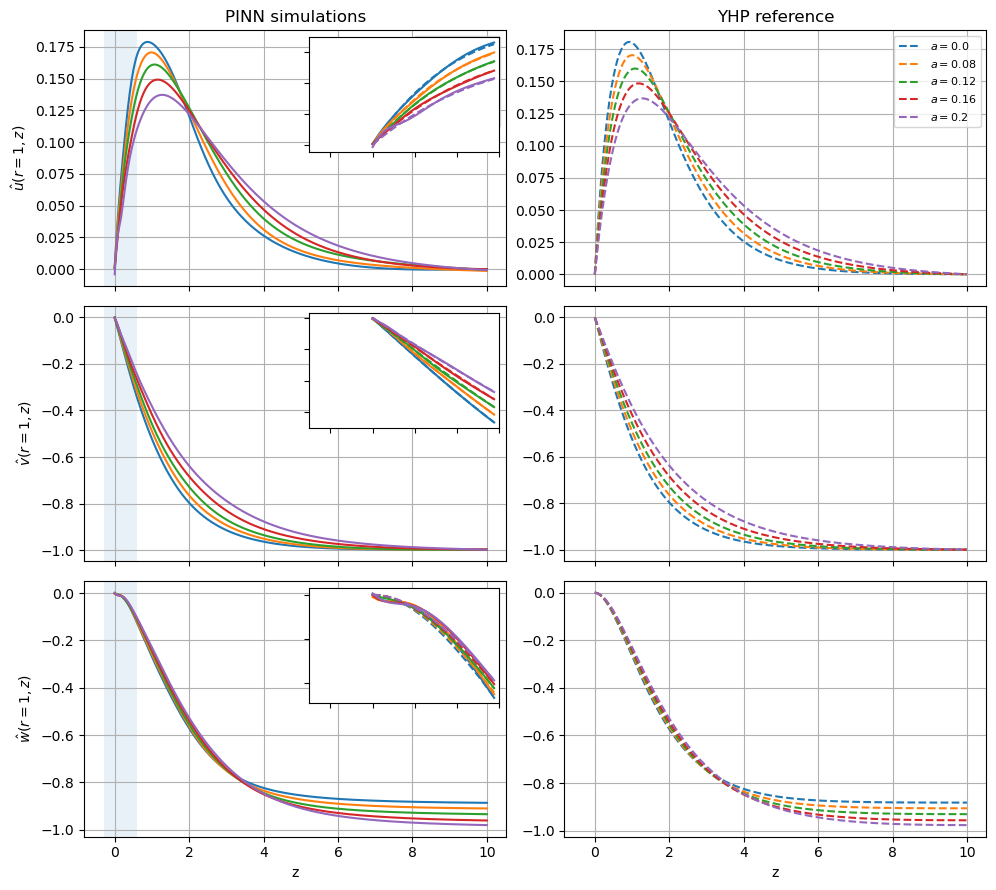

Zoom’lu (tüm δ) PINN + YHP referans profil figürü kaydedildi: Outputs_PINN_YHP_delta_sweep_196\PINN_vs_YHP_profiles_r1_all_delta_zoom_all.png
δ = 0.0 için Relative L2 hatalar:
  E_U     = 1.4735e-02
  E_V     = 1.6145e-03
  E_W     = 3.6512e-03
  E_comb  = 8.8138e-03
δ = 0.0 için Relative L2 hatalar:
  E_U     = 1.4735e-02
  E_V     = 1.6145e-03
  E_W     = 3.6512e-03
  E_comb  = 8.8138e-03

δ = 0.0 için key parametre relatif L2 hatalar:
  u'(0): ref = 0.51019731, PINN = 0.53945881, E_relL2 = 5.7353e-02
  v'(0): ref = -0.61592486, PINN = -0.68906409, E_relL2 = 1.1875e-01
  w(L):  ref = -0.88230261,  PINN = -0.88678813,  E_relL2 = 5.0839e-03
  Combined key-param error (u'(0), v'(0), w(L)) = 6.6258e-02


C:\Users\Serkan\AppData\Local\Temp\ipykernel_11852\4064867860.py:561: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_key = torch.load(ckpt_path_target, map_location=dev

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch_directml
import deepxde as dde
from scipy.integrate import solve_bvp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# -------------------------------------------------
# Environment / basic parameters
# -------------------------------------------------
os.environ["DDE_BACKEND"] = "pytorch"

device = torch_directml.device()
torch.set_default_device(device)
torch.set_default_dtype(torch.float32)

L = 10.0
r_min, r_max = 0.1, 1.0
Re = 196.0
delta = Re ** (-0.5)

neu = 64        
l = 4

# YHP roughness heights
delta_rough_list = [0.0, 0.08, 0.12, 0.16, 0.2]
nord = 1  # YHP geometry order

base_dir = "Outputs_PINN_YHP_delta_sweep_196"  # folder containing YHP PINN training outputs
# =================================================
# 1) YHP mean-flow numerical solver (for reference)
# =================================================
def s_function(delta_rough, gamma, r, nord):
    """MATLAB s_function: raw surface function (unscaled)."""
    r = np.asarray(r, dtype=float)
    s = np.zeros_like(r)
    sp = np.zeros_like(r)
    spp = np.zeros_like(r)

    for k in range(1, nord + 1):
        d = ((-1) ** k) * (1.0 / k)
        arg = 2.0 * np.pi * r * k / gamma
        s += d * np.cos(arg)
        sp += -d * np.sin(arg) * (2.0 * np.pi * k / gamma)
        spp += -d * np.cos(arg) * ((2.0 * np.pi * k / gamma) ** 2)

    return s, sp, spp

def amplitude(gamma, delta_rough, nord):
    x = np.linspace(0.0, gamma, 500)
    s, _, _ = s_function(delta_rough, gamma, x, nord)
    return np.max(s)

def s_scaled(delta_rough, gamma, r, nord, max_s):
    s, sp, spp = s_function(delta_rough, gamma, r, nord)
    if max_s != 0.0:
        factor = delta_rough / max_s
    else:
        factor = 0.0
    s *= factor
    sp *= factor
    spp *= factor
    return s, sp, spp

def karmanode(x, y):
    """
    VK ODE system.
    y[0]=f, y[1]=g, y[2]=h, y[3]=f', y[4]=g'
    """
    f = y[0, :]
    g = y[1, :]
    h = y[2, :]
    df = y[3, :]
    dg = y[4, :]

    uprime = f * f - (g + 1.0) * (g + 1.0) + h * df
    vprime = 2.0 * f * (g + 1.0) + h * dg

    dy_dx = np.vstack((
        df,          # f'
        dg,          # g'
        -2.0 * f,    # h'
        uprime,      # f''
        vprime       # g''
    ))
    return dy_dx

def karmanbc(ya, yb):
    """
    BC: f(0)=0, g(0)=0, h(0)=0, f(∞)=0, g(∞)=-1
    """
    return np.array([
        ya[0],
        ya[1],
        ya[2],
        yb[0],
        yb[1] + 1.0,
    ])

def karmanpde2(x, y, fr, gr, hr, dfr, dgr, xr,
               delta_rough, gamma, r, dr, nord, max_s):
    """
    YHP marching ODE system.
    """
    f1 = np.interp(x, xr, fr)
    g1 = np.interp(x, xr, gr)
    h1 = np.interp(x, xr, hr)

    # dfr, dgr interpolation is currently only for completeness; not used explicitly in equations
    df1 = np.interp(x, xr, dfr)
    dg1 = np.interp(x, xr, dgr)

    s, sp, spp = s_scaled(delta_rough, gamma, r, nord, max_s)

    f = y[0, :]
    g = y[1, :]
    h = y[2, :]
    df = y[3, :]
    dg = y[4, :]

    eq1 = -2.0 * f1 - r * (f - f1) / dr

    term1_2 = r * f1 * (f - f1) / dr
    term2_2 = h1 * df
    term3_2 = (1.0 + (r - dr) * sp * spp / (1.0 + sp**2)) * (f1**2)
    term4_2 = (1.0 + g1)**2 / (1.0 + sp**2)
    term5 = 1.0 + sp**2
    eq2 = (term1_2 + term2_2 + term3_2 - term4_2) / term5

    term1_3 = r * f1 * (g - g1) / dr
    term2_3 = h1 * dg
    term3_3 = 2.0 * f1 * (1.0 + g1)
    eq3 = (term1_3 + term2_3 + term3_3) / term5

    dy_dx = np.vstack((
        df,   # y1'
        dg,   # y2'
        eq1,  # y3'
        eq2,  # y4'
        eq3   # y5'
    ))
    return dy_dx

def solve_yhp_mean_profiles(delta_rough, nord,
                            upper_z=10.0, gamma=1.0, nmax=100):
    """
    Solves YHP mean-flow profiles (fbar, gbar, hbar) for a single delta_rough and nord.
    """
    max_s = amplitude(gamma, delta_rough, nord)
    dr = gamma / nmax

    # Seed with base VK
    z_mesh = np.linspace(0.0, upper_z, 100)
    y_init = np.zeros((5, z_mesh.size))
    y_init[0, :] = 0.1
    y_init[1, :] = -1.0
    y_init[2, :] = -1.0
    y_init[3, :] = 0.0
    y_init[4, :] = 0.0

    sol = solve_bvp(karmanode, karmanbc, z_mesh, y_init,
                    tol=1e-8, max_nodes=10000)
    if sol.status != 0:
        print("WARNING: base-flow BVP did not converge, status =", sol.status)

    xvK = np.linspace(0.0, upper_z, 2000)
    yvK = sol.sol(xvK)
    fr = yvK[0, :]
    gr = yvK[1, :]
    hr = yvK[2, :]
    dfr = yvK[3, :]
    dgr = yvK[4, :]
    xr = xvK

    fall = []
    gall = []
    hall = []
    dfall = []
    dgall = []

    for n in range(1, nmax + 1):
        r = n * dr
        y_init_n = np.vstack((fr, gr, hr, dfr, dgr))

        sol_n = solve_bvp(
            lambda x, y: karmanpde2(
                x, y, fr, gr, hr, dfr, dgr, xr,
                delta_rough, gamma, r, dr, nord, max_s
            ),
            karmanbc,
            xr,
            y_init_n,
            tol=1e-8,
            max_nodes=10000
        )
        if sol_n.status != 0:
            print(f"  WARNING: BVP did not converge at step n={n}, status={sol_n.status}")

        y_n = sol_n.sol(xr)
        fr = y_n[0, :]
        gr = y_n[1, :]
        hr = y_n[2, :]
        dfr = y_n[3, :]
        dgr = y_n[4, :]

        fall.append(fr)
        gall.append(gr)
        hall.append(hr)
        dfall.append(dfr)
        dgall.append(dgr)

    fall = np.array(fall)
    gall = np.array(gall)
    hall = np.array(hall)

    fbar = fall.mean(axis=0)
    gbar = gall.mean(axis=0)
    hbar = hall.mean(axis=0)

    return xr, fbar, gbar, hbar

def generate_obs_profiles_from_yhp(Re, delta_rough, nord,
                                   r_obs, L, n_z_obs,
                                   upper_z=10.0, gamma=1.0, nmax=100):
    """
    Generate U, V, W profiles at r=r_obs from YHP mean flow (for reference).
    """
    eta_grid, fbar, gbar, hbar = solve_yhp_mean_profiles(
        delta_rough, nord, upper_z=upper_z, gamma=gamma, nmax=nmax
    )

    delta_Re = Re ** (-0.5)

    z_obs = np.linspace(0.0, L, n_z_obs)
    eta_obs = z_obs
    eta_obs_clipped = np.clip(eta_obs, eta_grid[0], eta_grid[-1])

    f_obs = np.interp(eta_obs_clipped, eta_grid, fbar)
    g_obs = np.interp(eta_obs_clipped, eta_grid, gbar)
    h_obs = np.interp(eta_obs_clipped, eta_grid, hbar)

    U_obs = (r_obs * f_obs).reshape(-1, 1)
    V_obs = (r_obs * g_obs).reshape(-1, 1)
    W_obs = (h_obs).reshape(-1, 1)

    X_obs = np.column_stack(
        [r_obs * np.ones_like(z_obs), z_obs]
    ).astype(np.float32)
    z_obs = z_obs.reshape(-1, 1).astype(np.float32)

    return X_obs, U_obs.astype(np.float32), V_obs.astype(np.float32), \
        W_obs.astype(np.float32), z_obs

# -------------------------------------------------
# 2) Network architecture (identical to training)
# -------------------------------------------------
def build_net():
    layers = [2] + [neu] * l + [4]
    net = dde.nn.FNN(layers, "tanh", "Glorot uniform")

    def feature_transform(x):
        r = x[:, 0:1]
        z = x[:, 1:2]
        eta = z/delta
        return torch.cat([r, eta], dim=1)

    def output_transform(x, y):
        r = x[:, 0:1]
        U = r * y[:, 0:1]
        V = r * y[:, 1:2]
        W = delta * y[:, 2:3]
        P = (delta ** 2) * y[:, 3:4]
        return torch.cat([U, V, W, P], dim=1)

    net.apply_feature_transform(feature_transform)
    net.apply_output_transform(output_transform)
    net.to(device)
    return net

# -------------------------------------------------
# 3) Evaluation grid (r=1, z∈[0,L])
# -------------------------------------------------
n_plot = 400
z_eval = np.linspace(0.0, L, n_plot, dtype=np.float32).reshape(-1, 1)
r_eval = np.ones_like(z_eval, dtype=np.float32)
X_eval = np.hstack([r_eval, z_eval])  # (N,2)
z_plot = z_eval.flatten()

# Dictionaries to store results
U_all, V_all, W_all = {}, {}, {}           # PINN
U_ref_all, V_ref_all, W_ref_all = {}, {}, {}   # YHP reference

colors = ["C0", "C1", "C2", "C3", "C4"]

# -------------------------------------------------
# 4) For each delta_rough: PINN output and YHP reference profiles
# -------------------------------------------------
for delta_rough in delta_rough_list:
    # ----- PINN side -----
    run_dir = os.path.join(
        base_dir,
        f"YHP_Re{int(Re)}_delta{delta_rough:.3f}_{neu}x{l}"
    )

    ckpts = sorted(glob.glob(os.path.join(run_dir, "model_adam-*")))
    if not ckpts:
        print(f"[WARNING] Checkpoint not found: {run_dir}")
        continue

    ckpt_path = ckpts[-1]
    print(f"δ={delta_rough}: loading checkpoint -> {ckpt_path}")

    net = build_net()
    state = torch.load(ckpt_path, map_location=device)

    if isinstance(state, dict) and "model_state_dict" in state:
        net.load_state_dict(state["model_state_dict"])
    else:
        net.load_state_dict(state)

    net.eval()

    with torch.no_grad():
        x_t = torch.tensor(X_eval, dtype=torch.float32, device=device)
        y_t = net(x_t)             # after output_transform: [U,V,W,P]
        y_pred = y_t.cpu().numpy()

    U_all[delta_rough] = y_pred[:, 0]
    V_all[delta_rough] = y_pred[:, 1]
    W_all[delta_rough] = y_pred[:, 2]

    # ----- YHP reference side -----
    X_ref, U_ref, V_ref, W_ref, z_ref = generate_obs_profiles_from_yhp(
        Re=Re,
        delta_rough=delta_rough,
        nord=nord,
        r_obs=1.0,
        L=L,
        n_z_obs=n_plot,
        upper_z=L,
        gamma=1.0,
        nmax=100,
    )

    # z_ref is already linspace [0,L]
    U_ref_all[delta_rough] = U_ref[:, 0]
    V_ref_all[delta_rough] = V_ref[:, 0]
    W_ref_all[delta_rough] = W_ref[:, 0]

# -------------------------------------------------
# 5) Combined U, V, W plots (PINN vs YHP reference) + zoom inset
# -------------------------------------------------
fig, axes = plt.subplots(3, 2, figsize=(10, 9), sharex=True)

z0, z1 = -0.3, 0.6  # zoom region
mask = (z_plot >= z0) & (z_plot <= z1)

# --- U row ---
for d_rough, color in zip(delta_rough_list, colors):
    if d_rough not in U_all or d_rough not in U_ref_all:
        continue
    label = rf"$a={d_rough}$"
    axes[0, 0].plot(z_plot, U_all[d_rough], color=color, label=label)
    axes[0, 1].plot(z_ref[:, 0], U_ref_all[d_rough], color=color, linestyle="--", label=label)

axes[0, 0].set_ylabel(r"$\hat{u}(r=1,z)$")
axes[0, 0].set_title(r"PINN simulations")
axes[0, 1].set_title("YHP reference")

# --- V row ---
for d_rough, color in zip(delta_rough_list, colors):
    if d_rough not in V_all or d_rough not in V_ref_all:
        continue
    label = rf"$a={d_rough}$"
    axes[1, 0].plot(z_plot, V_all[d_rough], color=color, label=label)
    axes[1, 1].plot(z_ref[:, 0], V_ref_all[d_rough], color=color, linestyle="--", label=label)

axes[1, 0].set_ylabel(r"$\hat{v}(r=1,z)$")

# --- W row ---
for d_rough, color in zip(delta_rough_list, colors):
    if d_rough not in W_all or d_rough not in W_ref_all:
        continue
    label = rf"$a={d_rough}$"
    axes[2, 0].plot(z_plot, W_all[d_rough], color=color, label=label)
    axes[2, 1].plot(z_ref[:, 0], W_ref_all[d_rough], color=color, linestyle="--", label=label)

axes[2, 0].set_ylabel(r"$\hat{w}(r=1,z)$")
axes[2, 0].set_xlabel("z")
axes[2, 1].set_xlabel("z")

# --- Zoom insets ---
# U inset
ax_main = axes[0, 0]
ax_main.axvspan(z0, z1, alpha=0.1)
ax_inset_U = inset_axes(ax_main, width="45%", height="45%", loc="upper right")
ax_inset_U.set_xticklabels([])
ax_inset_U.set_yticklabels([])
for d_rough, color in zip(delta_rough_list, colors):
    if d_rough not in U_all or d_rough not in U_ref_all:
        continue
    ax_inset_U.plot(z_plot[mask], U_all[d_rough][mask], color=color)
    ax_inset_U.plot(z_plot[mask], U_ref_all[d_rough][mask], color=color, linestyle="--")
ax_inset_U.set_xlim(z0, z1)
ax_inset_U.tick_params(labelsize=7)

# V inset
ax_main = axes[1, 0]
ax_main.axvspan(z0, z1, alpha=0.1)
ax_inset_V = inset_axes(ax_main, width="45%", height="45%", loc="upper right")
ax_inset_V.set_xticklabels([])
ax_inset_V.set_yticklabels([])
for d_rough, color in zip(delta_rough_list, colors):
    if d_rough not in V_all or d_rough not in V_ref_all:
        continue
    ax_inset_V.plot(z_plot[mask], V_all[d_rough][mask], color=color)
    ax_inset_V.plot(z_plot[mask], V_ref_all[d_rough][mask], color=color, linestyle="--")
ax_inset_V.set_xlim(z0, z1)
ax_inset_V.tick_params(labelsize=7)

# W inset
ax_main = axes[2, 0]
ax_main.axvspan(z0, z1, alpha=0.1)
ax_inset_W = inset_axes(ax_main, width="45%", height="45%", loc="upper right")
ax_inset_W.set_xticklabels([])
ax_inset_W.set_yticklabels([])
for d_rough, color in zip(delta_rough_list, colors):
    if d_rough not in W_all or d_rough not in W_ref_all:
        continue
    ax_inset_W.plot(z_plot[mask], W_all[d_rough][mask], color=color)
    ax_inset_W.plot(z_plot[mask], W_ref_all[d_rough][mask], color=color, linestyle="--")
ax_inset_W.set_xlim(z0, z1)
ax_inset_W.tick_params(labelsize=7)

# Grid + legend
for i in range(3):
    for j in range(2):
        axes[i, j].grid(True)

axes[0, 0].legend(loc="best", fontsize=8)
axes[0, 1].legend(loc="best", fontsize=8)

plt.tight_layout()
out_fig = os.path.join(base_dir, "PINN_vs_YHP_profiles_r1_all_delta_zoom_all.png")
out_fig2 = os.path.join(base_dir, "PINN_vs_YHP_profiles_r1_all_delta_zoom_all.pdf")

plt.savefig(out_fig, dpi=200)
plt.savefig(out_fig2, dpi=200)
plt.show()

print("Zoomed (all δ) PINN + YHP reference profile figure saved:", out_fig)

# =================================================
# 6) Relative L2 error for a selected δ_rough
# =================================================

def rel_L2(pred, ref):
    """Relative L2 norm."""
    pred = np.asarray(pred)
    ref  = np.asarray(ref)
    num = np.sum((pred - ref)**2)
    den = np.sum(ref**2) + 1e-16
    return np.sqrt(num / den)

# Select here the roughness height you want to compare:
delta_target = 0.0   # Example: δ = 0.12; change as needed

if delta_target not in U_all or delta_target not in U_ref_all:
    print(f"[WARNING] For delta_target = {delta_target}, both PINN and reference profiles are not available.")
else:
    # PINN predictions
    U_p = U_all[delta_target]
    V_p = V_all[delta_target]
    W_p = W_all[delta_target]

    # YHP reference profiles
    U_r = U_ref_all[delta_target]
    V_r = V_ref_all[delta_target]
    W_r = W_ref_all[delta_target]

    # Relative L2 errors
    E_U = rel_L2(U_p, U_r)
    E_V = rel_L2(V_p, V_r)
    E_W = rel_L2(W_p, W_r)
    E_comb = np.sqrt((E_U**2 + E_V**2 + E_W**2) / 3.0)

    print(f"Relative L2 errors for δ = {delta_target}:")
    print(f"  E_U     = {E_U:.4e}")
    print(f"  E_V     = {E_V:.4e}")
    print(f"  E_W     = {E_W:.4e}")
    print(f"  E_comb  = {E_comb:.4e}")

    # Relative L2 errors
    E_U = rel_L2(U_p, U_r)
    E_V = rel_L2(V_p, V_r)
    E_W = rel_L2(W_p, W_r)
    E_comb = np.sqrt((E_U**2 + E_V**2 + E_W**2) / 3.0)

    print(f"Relative L2 errors for δ = {delta_target}:")
    print(f"  E_U     = {E_U:.4e}")
    print(f"  E_V     = {E_V:.4e}")
    print(f"  E_W     = {E_W:.4e}")
    print(f"  E_comb  = {E_comb:.4e}")

    # ============================================
    # Extra: comparison of u'(0), v'(0), w(L) for YHP
    # ============================================

    # --- 1) YHP reference key parameters ---
    # Solve YHP mean-flow profiles
    eta_grid, fbar, gbar, hbar = solve_yhp_mean_profiles(
        delta_rough=delta_target,
        nord=nord,
        upper_z=L,
        gamma=1.0,
        nmax=100,
    )

    # η grid spacing (assumed uniform)
    deta = eta_grid[1] - eta_grid[0]

    # Second-order forward difference: f'(0) ≈ (-3f0 + 4f1 - f2)/(2Δη)
    f0, f1, f2 = fbar[0], fbar[1], fbar[2]
    g0, g1, g2 = gbar[0], gbar[1], gbar[2]

    u_z0_ref = (-3.0 * f0 + 4.0 * f1 - f2) / (2.0 * deta)
    v_z0_ref = (-3.0 * g0 + 4.0 * g1 - g2) / (2.0 * deta)

    # w(L): interpolation of hbar(η = L)
    w_L_ref = float(np.interp(L, eta_grid, hbar))

    # --- 2) PINN key parameters ---
    # Reload the network for the selected δ (key parameters along r=1 line)
    run_dir_target = os.path.join(
        base_dir,
        f"YHP_Re{int(Re)}_delta{delta_target:.3f}_{neu}x{l}"
    )
    ckpts_target = sorted(glob.glob(os.path.join(run_dir_target, "model_adam-*")))
    if not ckpts_target:
        print(f"[WARNING] For delta_target = {delta_target}, no checkpoint found; key parameters could not be computed.")
    else:
        ckpt_path_target = ckpts_target[-1]
        net_key = build_net()
        state_key = torch.load(ckpt_path_target, map_location=device)

        if isinstance(state_key, dict) and "model_state_dict" in state_key:
            net_key.load_state_dict(state_key["model_state_dict"])
        else:
            net_key.load_state_dict(state_key)
        net_key.eval()

        # Wall point: r=1, z=0 -> u_z(0), v_z(0)
        with torch.enable_grad():
            x_wall = torch.tensor(
                [[1.0, 0.0]],
                dtype=torch.float32,
                device=device,
                requires_grad=True,
            )
            y_wall = net_key(x_wall)   # [U,V,W,P]
            U_wall = y_wall[:, 0:1]
            V_wall = y_wall[:, 1:2]

            gradU = torch.autograd.grad(
                U_wall, x_wall,
                torch.ones_like(U_wall),
                retain_graph=True,
            )[0]
            gradV = torch.autograd.grad(
                V_wall, x_wall,
                torch.ones_like(V_wall),
            )[0]

            u_z0_pred = gradU[0, 1].item()  # dU/dz
            v_z0_pred = gradV[0, 1].item()  # dV/dz

        # Far field: r=1, z=L -> w(L)
        x_far = torch.tensor(
            [[1.0, L]],
            dtype=torch.float32,
            device=device,
        )
        with torch.no_grad():
            y_far = net_key(x_far)
            w_L_pred = y_far[0, 2].item()   # W component

        # --- 3) Relative L2 for key scalars ---
        E_u_z0 = rel_L2(
            np.array([u_z0_pred], dtype=np.float64),
            np.array([u_z0_ref],  dtype=np.float64),
        )
        E_v_z0 = rel_L2(
            np.array([v_z0_pred], dtype=np.float64),
            np.array([v_z0_ref],  dtype=np.float64),
        )
        E_w_L  = rel_L2(
            np.array([w_L_pred],  dtype=np.float64),
            np.array([w_L_ref],   dtype=np.float64),
        )

        E_comb_key = rel_L2(
            np.array([u_z0_pred, v_z0_pred, w_L_pred], dtype=np.float64),
            np.array([u_z0_ref,  v_z0_ref,  w_L_ref],  dtype=np.float64),
        )

        print(f"\nKey-parameter relative L2 errors for δ = {delta_target}:")
        print(f"  u'(0): ref = {u_z0_ref:.8f}, PINN = {u_z0_pred:.8f}, E_relL2 = {E_u_z0:.4e}")
        print(f"  v'(0): ref = {v_z0_ref:.8f}, PINN = {v_z0_pred:.8f}, E_relL2 = {E_v_z0:.4e}")
        print(f"  w(L):  ref = {w_L_ref:.8f},  PINN = {w_L_pred:.8f},  E_relL2 = {E_w_L:.4e}")
        print(f"  Combined key-parameter error (u'(0), v'(0), w(L)) = {E_comb_key:.4e}")
